# Collaborative filtering on Google Analytics data

This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

In [1]:
import os
PROJECT = "qwiklabs-gcp-327dc59ea18f1998" # REPLACE WITH YOUR PROJECT ID
BUCKET = "qwiklabs-gcp-327dc59ea18f1998" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.13"

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

1.14.0


## Create raw dataset
<p>
For collaborative filtering, we don't need to know anything about either the users or the content. Essentially, all we need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, we are working with newspaper articles. The company doesn't ask their users to rate the articles. However, we can use the time-spent on the page as a proxy for rating.
<p>
Normally, we would also add a time filter to this ("latest 7 days"), but our dataset is itself limited to a few days.

In [4]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

sql = """
#standardSQL
WITH CTE_visitor_page_content AS (
    SELECT
        fullVisitorID,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"

    GROUP BY   
        fullVisitorId,
        latestContentId,
        hits.time )

-- Aggregate web stats
SELECT   
    fullVisitorID as visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    fullVisitorID, 
    latestContentId
HAVING 
    session_duration > 0
ORDER BY 
    latestContentId 
"""

df = bq.query(sql).to_dataframe()
df.head()

,visitorId,contentId,session_duration
0,7337153711992174438,100074831,44652
1,5190801220865459604,100170790,1214205
2,2293633612703952721,100510126,47744
3,5874973374932455844,100510126,32109
4,1173698801255170595,100676857,10512


In [5]:
stats = df.describe()
stats

,session_duration
count,2.796450e+05
mean,1.269510e+05
std,2.343652e+05
min,1.000000e+00
25%,1.697400e+04
50%,5.770200e+04
75%,1.291740e+05
max,7.690598e+06


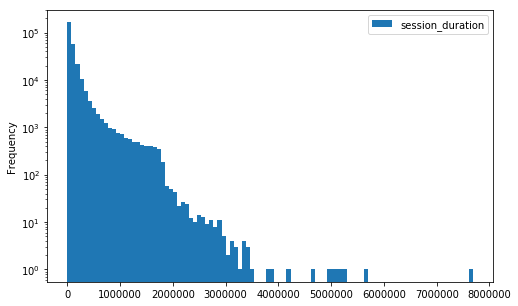

In [6]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

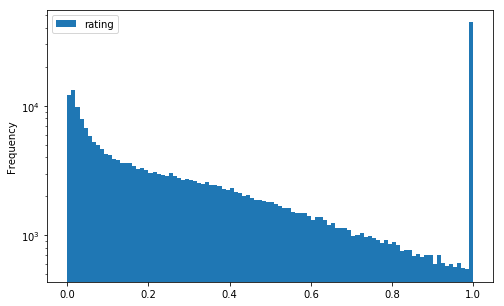

In [7]:
# The rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc["50%", "session_duration"]
df["rating"] = 0.3 * df["session_duration"] / median
df.loc[df["rating"] > 1, "rating"] = 1
df[["rating"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

In [8]:
del df["session_duration"]

In [9]:
%%bash
rm -rf data
mkdir data

In [10]:
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)

In [11]:
!head data/collab_raw.csv

7337153711992174438,100074831,0.23215139856504108
5190801220865459604,100170790,1.0
2293633612703952721,100510126,0.24822709784756158
5874973374932455844,100510126,0.16693875428927937
1173698801255170595,100676857,0.054653218259332434
883397426232997550,10083328,0.9488925860455444
1808867070685560283,100906145,1.0
7615995624631762562,100906145,0.4842830404492045
5519169380728479914,100915139,0.20030154933971092
3427736932800080345,100950628,0.5590360819382344


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so we need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> We will need to save the above mapping to a file because at prediction time, we'll need to know how to map the contentId in the table above to the itemId.
<li> We'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [12]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
    with open(filename, 'w') as ofp:
        value_to_id = {value:idx for idx, value in enumerate(values.unique())}
        for value, idx in value_to_id.items():
            ofp.write("{},{}\n".format(value, idx))
    return value_to_id

df = pd.read_csv(filepath_or_buffer = "data/collab_raw.csv",
                 header = None,
                 names = ["visitorId", "contentId", "rating"],
                dtype = {"visitorId": str, "contentId": str, "rating": np.float})
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)
user_mapping = create_mapping(df["visitorId"], "data/users.csv")
item_mapping = create_mapping(df["contentId"], "data/items.csv")

In [13]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
7337153711992174438,100074831,0.2321513985650411
5190801220865459604,100170790,1.0
2293633612703952721,100510126,0.2482270978475616

==> data/items.csv <==
236941062,1416
299786600,4718
243874813,1556

==> data/users.csv <==
1672553935406836733,2301
3588200922529727879,41286
7789950935531938708,60716


In [14]:
df["userId"] = df["visitorId"].map(user_mapping.get)
df["itemId"] = df["contentId"].map(item_mapping.get)

In [15]:
mapped_df = df[["userId", "itemId", "rating"]]
mapped_df.to_csv(path_or_buf = "data/collab_mapped.csv", index = False, header = False)
mapped_df.head()

,userId,itemId,rating
0,0,0,0.232151
1,1,1,1.000000
2,2,2,0.248227
3,3,2,0.166939
4,4,3,0.054653


### Creating rows and columns datasets

In [16]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv(filepath_or_buffer = "data/collab_mapped.csv", header = None, names = ["userId", "itemId", "rating"])
mapped_df.head()

,userId,itemId,rating
0,0,0,0.232151
1,1,1,1.000000
2,2,2,0.248227
3,3,2,0.166939
4,4,3,0.054653


In [17]:
NITEMS = np.max(mapped_df["itemId"]) + 1
NUSERS = np.max(mapped_df["userId"]) + 1
mapped_df["rating"] = np.round(mapped_df["rating"].values, 2)
print("{} items, {} users, {} interactions".format( NITEMS, NUSERS, len(mapped_df) ))

5723 items, 82907 users, 279645 interactions


In [18]:
grouped_by_items = mapped_df.groupby("itemId")
iter = 0
for item, grouped in grouped_by_items:
    print(item, grouped["userId"].values, grouped["rating"].values)
    iter = iter + 1
    if iter > 5:
        break

(0, array([0]), array([0.23]))
(1, array([1]), array([1.]))
(2, array([2, 3]), array([0.25, 0.17]))
(3, array([4]), array([0.05]))
(4, array([5]), array([0.95]))
(5, array([6, 7]), array([1.  , 0.48]))


In [19]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby("itemId")
with tf.python_io.TFRecordWriter("data/users_for_item") as ofp:
    for item, grouped in grouped_by_items:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [item])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["userId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [20]:
grouped_by_users = mapped_df.groupby("userId")
with tf.python_io.TFRecordWriter("data/items_for_user") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [21]:
grouped_by_users = mapped_df.groupby("userId")
N = 0
with tf.python_io.TFRecordWriter("data/items_for_user_subset") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())    
        N = N + 1
        if N > 20:
            break

In [22]:
!ls -lrt data

total 31912
-rw-r--r-- 1 jupyter jupyter 13154315 Sep 26 06:03 collab_raw.csv
-rw-r--r-- 1 jupyter jupyter  2134644 Sep 26 06:03 users.csv
-rw-r--r-- 1 jupyter jupyter    82979 Sep 26 06:03 items.csv
-rw-r--r-- 1 jupyter jupyter  7813267 Sep 26 06:03 collab_mapped.csv
-rw-r--r-- 1 jupyter jupyter  2253188 Sep 26 06:03 users_for_item
-rw-r--r-- 1 jupyter jupyter  7218465 Sep 26 06:04 items_for_user
-rw-r--r-- 1 jupyter jupyter     1753 Sep 26 06:04 items_for_user_subset


To summarize, we created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, we write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, we use tf.contrib.learn.Experiment to handle the training loop.<p>
Make sure to replace <strong># TODO</strong> in below code.

In [ ]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
    def decode_example(protos, vocab_size):
        # TODO
        return
  
  
    def remap_keys(sparse_tensor):
        # Current indices of our SparseTensor that we need to fix
        bad_indices = sparse_tensor.indices # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)
        # Current values of our SparseTensor that we need to fix
        bad_values = sparse_tensor.values # shape = (current_batch_size * (number_of_items/users[i] + 1),)

        # Since batch is ordered, the last value for a batch index is the user
        # Find where the batch index chages to extract the user rows
        # 1 where user, else 0
        user_mask = tf.concat(values = [bad_indices[1:,0] - bad_indices[:-1,0], tf.constant(value = [1], dtype = tf.int64)], axis = 0) # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)

        # Mask out the user rows from the values
        good_values = tf.boolean_mask(tensor = bad_values, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        item_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        user_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 1))[:, 1] # shape = (current_batch_size,)

        good_user_indices = tf.gather(params = user_indices, indices = item_indices[:,0]) # shape = (current_batch_size * number_of_items/users[i],)

        # User and item indices are rank 1, need to make rank 1 to concat
        good_user_indices_expanded = tf.expand_dims(input = good_user_indices, axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_item_indices_expanded = tf.expand_dims(input = item_indices[:, 1], axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_indices = tf.concat(values = [good_user_indices_expanded, good_item_indices_expanded], axis = 1) # shape = (current_batch_size * number_of_items/users[i], 2)

        remapped_sparse_tensor = tf.SparseTensor(indices = good_indices, values = good_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor

    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(filename = os.path.join(args["input_path"], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(map_func = lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(count = num_epochs)
        dataset = dataset.batch(batch_size = args["batch_size"])
        dataset = dataset.map(map_func = lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
  
    def _input_fn():
        features = {
            WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords("items_for_user", args["nitems"]),
            WALSMatrixFactorization.INPUT_COLS: parse_tfrecords("users_for_item", args["nusers"]),
            WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None

    return _input_fn
  
    def input_cols():
        return parse_tfrecords("users_for_item", args["nusers"])
  
    return _input_fn#_subset

This code is helpful in developing the input function. You don't need it in production.

In [ ]:
def try_out():
    with tf.Session() as sess:
        fn = read_dataset(
            mode = tf.estimator.ModeKeys.EVAL, 
            args = {"input_path": "data", "batch_size": 4, "nitems": NITEMS, "nusers": NUSERS})
        feats, _ = fn()
        
        print(feats["input_rows"].eval())
        print(feats["input_rows"].eval())

try_out()

In [ ]:
def find_top_k(user, item_factors, k):
    all_items = tf.matmul(a = tf.expand_dims(input = user, axis = 0), b = tf.transpose(a = item_factors))
    topk = tf.nn.top_k(input = all_items, k = k)
    return tf.cast(x = topk.indices, dtype = tf.int64)
    
def batch_predict(args):
    import numpy as np
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        # This is how you would get the row factors for out-of-vocab user data
        # row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        # user_factors = tf.convert_to_tensor(np.array(row_factors))

        # But for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(value = estimator.get_row_factors()[0]) # (nusers, nembeds)
        # In either case, we have to assume catalog doesn"t change, so col_factors are read in
        item_factors = tf.convert_to_tensor(value = estimator.get_col_factors()[0])# (nitems, nembeds)

        # For each user, find the top K items
        topk = tf.squeeze(input = tf.map_fn(fn = lambda user: find_top_k(user, item_factors, args["topk"]), elems = user_factors, dtype = tf.int64))
        with file_io.FileIO(os.path.join(args["output_dir"], "batch_pred.txt"), mode = "w") as f:
            for best_items_for_user in topk.eval():
                f.write(",".join(str(x) for x in best_items_for_user) + "\n")

# Online prediction returns row and column factors as needed
def create_serving_input_fn(args):
    def for_user_embeddings(userId):
        # All items for this user (for user_embeddings)
        items = tf.range(args["nitems"], dtype = tf.int64)
        users = userId * tf.ones(shape = [args["nitems"]], dtype = tf.int64)
        ratings = 0.1 * tf.ones_like(tensor = users, dtype = tf.float32)
        return items, users, ratings, tf.constant(value = True, dtype = tf.bool)
    
    def for_item_embeddings(itemId):
        # All users for this item (for item_embeddings)
        users = tf.range(args["nusers"], dtype = tf.int64)
        items = itemId * tf.ones(shape = [args["nusers"]], dtype = tf.int64)
        ratings = 0.1 * tf.ones_like(tensor = users, dtype = tf.float32)
        return items, users, ratings, tf.constant(value = False, dtype = tf.bool)
    
    def serving_input_fn():
        feature_ph = {
            "userId": tf.placeholder(dtype = tf.int64, shape = 1),
            "itemId": tf.placeholder(dtype = tf.int64, shape = 1)
        }

        (items, users, ratings, project_row) = \
            tf.cond(pred = feature_ph["userId"][0] < tf.constant(value = 0, dtype = tf.int64),
                true_fn = lambda: for_item_embeddings(feature_ph["itemId"]),
                false_fn = lambda: for_user_embeddings(feature_ph["userId"]))
        rows = tf.stack(values = [users, items], axis = 1)
        cols = tf.stack(values = [items, users], axis = 1)
        input_rows = tf.SparseTensor(indices = rows, values = ratings, dense_shape = (args["nusers"], args["nitems"]))
        input_cols = tf.SparseTensor(indices = cols, values = ratings, dense_shape = (args["nusers"], args["nitems"]))

        features = {
            WALSMatrixFactorization.INPUT_ROWS: input_rows,
            WALSMatrixFactorization.INPUT_COLS: input_cols,
            WALSMatrixFactorization.PROJECT_ROW: project_row
        }
        return tf.contrib.learn.InputFnOps(features = features, labels = None, default_inputs = feature_ph)
    return serving_input_fn
        
def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args["num_epochs"] * args["nusers"]) / args["batch_size"])
    steps_in_epoch = int(0.5 + args["nusers"] / args["batch_size"])
    print("Will train for {} steps, evaluating once every {} steps".format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows = args["nusers"], 
                num_cols = args["nitems"],
                embedding_dimension = args["n_embeds"],
                model_dir = args["output_dir"]),
            train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps = train_steps,
            eval_steps = 1,
            min_eval_frequency = steps_in_epoch,
            export_strategies = tf.contrib.learn.utils.saved_model_export_utils.make_export_strategy(serving_input_fn = create_serving_input_fn(args))
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn = experiment_fn, output_dir = args["output_dir"])
    
    batch_predict(args)

In [ ]:
import shutil
shutil.rmtree("wals_trained", ignore_errors=True)
train_and_evaluate({
    "output_dir": "wals_trained",
    "input_path": "data/",
    "num_epochs": 0.05,
    "nitems": NITEMS,
    "nusers": NUSERS,

    "batch_size": 512,
    "n_embeds": 10,
    "topk": 3
  })

In [ ]:
!ls wals_trained

In [ ]:
!head wals_trained/batch_pred.txt

## Run as a Python module

Let's run it as Python module for just a few steps.

In [ ]:
os.environ["NITEMS"] = str(NITEMS)
os.environ["NUSERS"] = str(NUSERS)

In [ ]:
%%bash
rm -rf wals.tar.gz wals_trained
gcloud ml-engine local train \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    -- \
    --output_dir=${PWD}/wals_trained \
    --input_path=${PWD}/data \
    --num_epochs=0.01 --nitems=${NITEMS} --nusers=${NUSERS} \
    --job-dir=./tmp

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) using the serving input function that we exported.  We'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [ ]:
%writefile data/input.json
{"userId": 4, "itemId": -1}

In [ ]:
%%bash
MODEL_DIR=$(ls wals_trained/export/Servo | tail -1)
gcloud ml-engine local predict --model-dir=wals_trained/export/Servo/$MODEL_DIR --json-instances=data/input.json

In [ ]:
%writefile data/input.json
{"userId": -1, "itemId": 4}

In [ ]:
%%bash
MODEL_DIR=$(ls wals_trained/export/Servo | tail -1)
gcloud ml-engine local predict --model-dir=wals_trained/export/Servo/$MODEL_DIR --json-instances=data/input.json

## Run on Cloud

In [ ]:
%%bash
gsutil -m cp data/* gs://${BUCKET}/wals/data

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --input_path=gs://${BUCKET}/wals/data \
    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} 

This took <b>10 minutes</b> for me.

<pre>
# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>